In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
csv_path = '/content/drive/MyDrive/image_label_df_filtered.csv'
data = pd.read_csv(csv_path)

# Displaying first few rows
print(data.head())
print("Number of classes:", data['label'].nunique())

               case_id                               image_path  \
0 -1000600354148496558  dataset/images/-3205742176803893704.png   
1 -1000600354148496558  dataset/images/-3205742176803893704.png   
2 -1000600354148496558  dataset/images/-3205742176803893704.png   
3 -1002039107727665188  dataset/images/-4762289084741430925.png   
4 -1002039107727665188  dataset/images/-4762289084741430925.png   

                 image_name                        label  weighted_label  
0  -3205742176803893704.png       Inflicted skin lesions            0.41  
1  -3205742176803893704.png                       Eczema            0.41  
2  -3205742176803893704.png  Irritant Contact Dermatitis            0.18  
3  -4762289084741430925.png            Prurigo nodularis            0.41  
4  -4762289084741430925.png            Actinic Keratosis            0.18  
Number of classes: 329


In [ ]:
import pandas as pd
import os
base_dir = '/content/drive/MyDrive/'

# Adjust the image paths in the DataFrame
data['image_path'] = data['image_path'].apply(lambda x: os.path.join(base_dir, x))

# Verify the adjusted paths
print("Adjusted image paths:")
print(data['image_path'].head())

Adjusted image paths:
0    /content/drive/MyDrive/dataset/images/-3205742...
1    /content/drive/MyDrive/dataset/images/-3205742...
2    /content/drive/MyDrive/dataset/images/-3205742...
3    /content/drive/MyDrive/dataset/images/-4762289...
4    /content/drive/MyDrive/dataset/images/-4762289...
Name: image_path, dtype: object


In [ ]:
# Verifying if image exists
sample_paths = data['image_path'].head()
for path in sample_paths:
    if not os.path.exists(path):
        print(f"File not found: {path}")
    else:
        print(f"File found: {path}")

File found: /content/drive/MyDrive/dataset/images/-3205742176803893704.png
File found: /content/drive/MyDrive/dataset/images/-3205742176803893704.png
File found: /content/drive/MyDrive/dataset/images/-3205742176803893704.png
File found: /content/drive/MyDrive/dataset/images/-4762289084741430925.png
File found: /content/drive/MyDrive/dataset/images/-4762289084741430925.png


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

#  data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset=None
)


#  inspect the shapes
x_train, y_train = next(train_generator)
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_val, y_val = next(val_generator)
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')


Found 14796 validated image filenames belonging to 329 classes.
Found 3698 validated image filenames belonging to 329 classes.
Found 18494 validated image filenames belonging to 329 classes.
x_train shape: (32, 224, 224, 3)
y_train shape: (32, 329)
x_val shape: (32, 224, 224, 3)
y_val shape: (32, 329)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(329, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freezing layers of the base model
for layer in base_model.layers:
    layer.trainable = False


# Compile the model with the updated parameter
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# check the input and output shapes
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/10
462/462 [==============================] - 3554s 8s/step - loss: 4.6383 - accuracy: 0.1238 - val_loss: 4.2117 - val_accuracy: 0.1168
Epoch 2/10
462/462 [==============================] - 510s 1s/step - loss: 4.3407 - accuracy: 0.1279 - val_loss: 4.1010 - val_accuracy: 0.1353
Epoch 3/10
462/462 [==============================] - 496s 1s/step - loss: 4.2477 - accuracy: 0.1353 - val_loss: 4.0877 - val_accuracy: 0.1351
Epoch 4/10
462/462 [==============================] - 544s 1s/step - loss: 4.2078 - accuracy: 0.1417 - val_loss: 4.1079 - val_accuracy: 0.1351
Epoch 5/10
462/462 [==============================] - 548s 1s/step - loss: 4.1852 - accuracy: 0.1416 - val_loss: 4.1161 - val_accuracy: 0.1359
Epoch 6/10
462/462 [==============================] - 564s 1s/step - loss: 4.1664 - accuracy: 0.1445 - val_loss: 4.0664 - val_accuracy: 0.1353
Epoch 7/10
462/462 [==============================] - 566s 1s/step - loss: 4.1300 - accuracy: 0.1521 - val_loss: 4.0771 - val_accuracy: 0.134

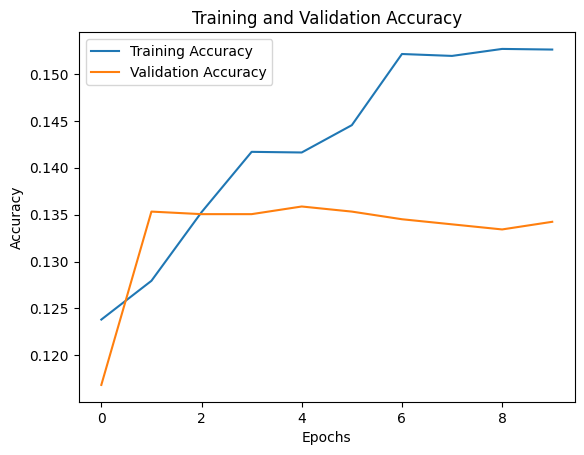

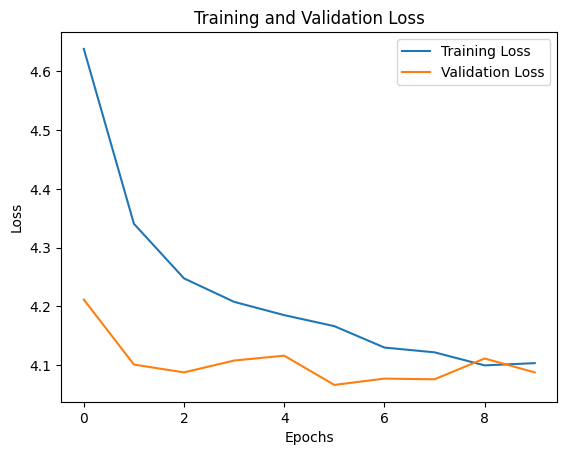

In [ ]:
# Plot training and validation accuracy/loss
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test Accuracy:', test_acc)


578/578 - 553s - loss: 3.9546 - accuracy: 0.1504 - 553s/epoch - 957ms/step
Test Accuracy: 0.15037310123443604


1/1 [==============================] - 0s 47ms/step


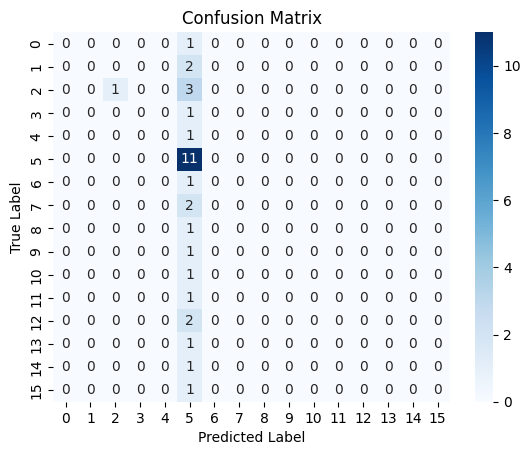

In [ ]:
import numpy as np
#Confusion Matrix
x_test, y_test = next(test_generator)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()